# Practico 3 y 4 (parte 8 a)

## Desempeño de Clasificador Stochastic Gradient Descent utilizando Vectorización de Dialogos

## Importación de módulos y librerías

In [1]:
# Inclusion de librerias y módulos
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

# Nos permite convertir str a list
from ast import literal_eval

# Separación
from sklearn.model_selection import train_test_split

# Gradiente Descendente
from sklearn.linear_model import SGDClassifier

# Vectorizador
from sklearn.feature_extraction.text import TfidfVectorizer

# Classification report
from sklearn.metrics import classification_report

# Colores
BLUE   = '#5DADE2'
RED    = '#ff7043'
ORANGE = '#F5B041'
GREEN  = '#58D68D'
YELLOW = '#F4D03F'
pltcolors = [BLUE, RED, ORANGE, GREEN, YELLOW]

# Plot axes y legends parambs
plt.rcParams["axes.labelweight"]   = "bold"
plt.rcParams["axes.titleweight"]   = "bold"
plt.rcParams["legend.shadow"]      = True
plt.rcParams["figure.titleweight"] = "bold"

data_dir = os.path.join('..', 'dataset', 'ablations')

### Definicicion de la tasa de ablación y casos de análisis

Consideramos la tasa de abalación en el intérvalo que va del 20% de los turnos hasta el 100% de los turnos con incrementos de 20%. El objtivo es analizar el impacto o relevancia del contenido de los turnos variando la cantidad de los mismos. A su vez, para cada caso de abalación, consideramos tres escenarios diferentes. El primer escenario consiste en utilizar en el análisis los turnos de estudiantes y tutores. El segundo escenario consiste en solo considerar los turnos corresponidientes a los estudiantes, mientras que, en el tercer y último escenario se considerarn solo los turnos de los tutores. Tal como mencionamos con aterioridad, el objetivo perseguido en este proceso es observar el impacto de cada uno de los paticipantes en el proceso de calificacion de la sesión.

In [2]:
tokeep_list = [0.2, 0.4 , 0.6, 0.8, 1.0]
participantes = ['students_tutors', 'students', 'tutors']

### Procedimiento

1. Cargamos los conjuntos de datos, a los cuales ya se les ha relizado el proceso de ablación. Optamos por proceder de este modo para dejar fuera del bucle el costo de procesamiento de la ablación. Es necsario destacar que el conjuto de datos `yup_messages_ablated_{}_{}.csv` se genera a partir de los conjuntos de datos `yup_messages_preprocessed.csv` y `datadump-20150801-20171219.csv`.
2. Separamos el conjunto de datos en los sub conjuntos de características `X` y objetivo `y`. El conjunto de caracteríisticas es previamente convertido de tipo str a list con elementos del tipo str.
3. Dividimos el conjuto de datos en los sub conjuntos train y test en una proporción del 80% y 20% del total respectivamente.
4. Utilizamos [TfidfVectorizer](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) para vectorizar el conjunto de datos o corpus dado que algunas palabras estarán muy presentes, por lo que llevarán muy poca información significativa sobre el contenido real del documento. Si fuéramos a alimentar los datos de conteo directo a un clasificador, esos términos muy frecuentes ensombrecerían las frecuencias de términos más raros pero más interesantes.
5. Por simplisidad consideramos el `SGDClassifier` con los parametros por defecto.
6. Se generan los reportes de desempeño del clasificador para ambos conjuntos (train y test)
7. Se genera el log de variable spara cada caso de análisis.

In [3]:
results = dict()
for part in participantes:

    results[part] = dict()
    for tk in tokeep_list:
        print(f'>> Tipo de participante {part} y ablation al {tk:05.2f}...')

        #1. Carga de los datasets
        fname = f'yup_messages_ablated_{tk:05.2f}_{part}.csv'
        fpath = os.path.join(data_dir, fname)
        df = pd.read_csv(fpath)

        #2. Separacion en features y target
        X = df.text.apply(lambda x: ' '.join(literal_eval(x)))
        y = df.student_rating
        
        #3. Division en conjunto de train y test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        #4. Vectorizacion: Entrenamiento y transformación de los conjuntos de train y test
        vectorizer = TfidfVectorizer()
        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)

        #5. Clasificador Stochastic Gradient Descent: Entrenamiento y clasificación
        SGD = SGDClassifier(random_state=42)
        SGD.fit(X_train, y_train)
        y_train_SGD = SGD.predict(X_train)
        y_test_SGD = SGD.predict(X_test)

        #6. Reportes de clasificación
        cr_train = classification_report(y_train, y_train_SGD, output_dict=True)
        cr_test = classification_report(y_test, y_test_SGD, output_dict=True)

        #7. Log de resultados
        results[part][f'{tk:05.2f}'] = dict()
        results[part][f'{tk:05.2f}']['size_train'] = X_train.shape
        results[part][f'{tk:05.2f}']['size_test'] = X_test.shape
        results[part][f'{tk:05.2f}']['cr_train'] = cr_train
        results[part][f'{tk:05.2f}']['cr_test'] = cr_test

>> Tipo de participante students_tutors y ablation al 00.20...
>> Tipo de participante students_tutors y ablation al 00.40...
>> Tipo de participante students_tutors y ablation al 00.60...
>> Tipo de participante students_tutors y ablation al 00.80...
>> Tipo de participante students_tutors y ablation al 01.00...
>> Tipo de participante students y ablation al 00.20...
>> Tipo de participante students y ablation al 00.40...
>> Tipo de participante students y ablation al 00.60...
>> Tipo de participante students y ablation al 00.80...
>> Tipo de participante students y ablation al 01.00...
>> Tipo de participante tutors y ablation al 00.20...
>> Tipo de participante tutors y ablation al 00.40...
>> Tipo de participante tutors y ablation al 00.60...
>> Tipo de participante tutors y ablation al 00.80...
>> Tipo de participante tutors y ablation al 01.00...


### Procesamiento del log de resultados

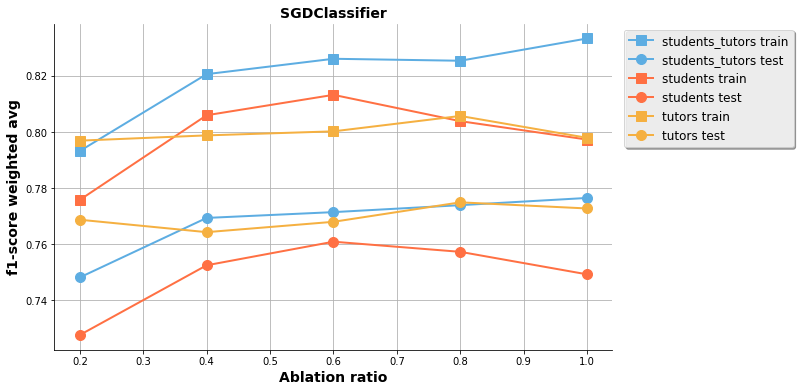

In [4]:
sizeh_train = list()
sizeh_test = list()
sizew_train = list()
sizew_test = list()
ps = list()
tks = list()

plt.figure(figsize=(10,6))
for i,part in enumerate(participantes):
    f1_train = list()
    f1_test = list()
    for tk in tokeep_list:
        f1_train.append(results[part][f'{tk:05.2f}']['cr_train']['weighted avg']['f1-score'])
        f1_test.append(results[part][f'{tk:05.2f}']['cr_test']['weighted avg']['f1-score'])
        sizeh_train.append(results[part][f'{tk:05.2f}']['size_train'][0])
        sizeh_test.append(results[part][f'{tk:05.2f}']['size_test'][0])
        sizew_train.append(results[part][f'{tk:05.2f}']['size_train'][1])
        sizew_test.append(results[part][f'{tk:05.2f}']['size_test'][1])
        ps.append(part)
        tks.append(tk)

    plt.plot(tokeep_list, f1_train, 's-', color=pltcolors[i], linewidth=2.0, markersize=10, label=f'{part} train')
    plt.plot(tokeep_list, f1_test, 'o-', color=pltcolors[i], linewidth=2.0, markersize=10, label=f'{part} test')


plt.grid(True)
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left",fontsize=12)
plt.xlabel('Ablation ratio', fontsize=14)
plt.ylabel('f1-score weighted avg', fontsize=14)
plt.title('SGDClassifier', fontsize=14)
sns.despine()

sizes_matrix = dict()
sizes_matrix['participant'] = ps
sizes_matrix['ablation'] = tks
sizes_matrix['rows_train'] = sizeh_train
sizes_matrix['cols_train'] = sizew_train
sizes_matrix['rows_test'] = sizeh_test
sizes_matrix['cols_test'] = sizew_test

sizes_matrix = pd.DataFrame(sizes_matrix)
sizes_matrix['rows_total'] = sizes_matrix.rows_train + sizes_matrix.rows_test

## Análisis

A los fines del análisis selecionamos la métrica `f1-score weighted avg` dado que la misma representa un mayor comporomiso y balance entre precision y recall y por que la misma se encuentra disponible en los prácticos anteriores a modo de referencia. Para el caso del presente clasificador en el [Practico_3y4_part2.ipynb](file://Practico_3y4_part2.ipynb) se obtuvieron los valores

<center> * Train: 0.759
<center> * Test : 0.755

Tomando como referencia los resultados obtenidos con los conjuntos de test, podemos obsevar que el desempeño del clasificador utilizando solo turnos de los tutores se muestra relativamente constante respecto al grado de ablación al rededor del valor 0.77. En términos de desempeño relativo, el classificador mencionado presenta mejor desempeño en todo el rango respecto a clasificador entranado solo con dialogos de estudiantes y a partir del 40% de tasa de ablación se observa que el clasificador entrenado con dialogos de estudiantes y tutores se comporta muy similar al caso de solo tutores.

En base a como se efectúa el proceso de ablación, donde consideramos los turnos desde el final hacia el inicio del diálogo, y si hacemos foco en el escenario de solo estudiantes, podemos suponer que los últimos turnos de los estudiantes proveen menos información en relación al éxito o fracaso de la sesión, en particular esto se evidencia en el rango de ablación que va desde 0.2 a 0.6. A su vez, podemos suponer que los ultimos turnos son predominantemente de los estudiantes dado el alto grado de acoplamiento que se observa entre los casos de totores con estudiantes y solo estudiantes en el rango mencionado. 

Finalmente, si cosideramos el rango de ablación que se extiende a parti de 0.6 podemos observar que el caso correspondiente a estudiantes mas tutores mantiene o incrementa sutilmente el desempeño en concordancia con la curva correspondiente a solo tutores. Esto puede significar que en el caso de tutores mas estudiante a apartir del 60% de ablación comienza a incorporar turnos de los tutores, los cuales en base a los resultados observados proveen informacion del resultado de la sesión y predominanteente al final del dialogo. Esto se puede afirmar dado la relativa estabilidad de la curva de tutores.

In [5]:
display(sizes_matrix)

,participant,ablation,rows_train,cols_train,rows_test,cols_test,rows_total
0,students_tutors,0.2,13943,14587,3486,14587,17429
1,students_tutors,0.4,13943,20791,3486,20791,17429
2,students_tutors,0.6,13943,25495,3486,25495,17429
3,students_tutors,0.8,13943,29476,3486,29476,17429
4,students_tutors,1.0,13943,33151,3486,33151,17429
5,students,0.2,13939,9258,3485,9258,17424
6,students,0.4,13939,13706,3485,13706,17424
7,students,0.6,13939,17156,3485,17156,17424
8,students,0.8,13939,19979,3485,19979,17424
9,students,1.0,13939,21704,3485,21704,17424


### Tamaños de los conjuntos y vectorización

En la tabla superior es posible observar el dimensionamiento del conjunto de datos. En primera instancia podemos observar que el número de casos o entradas en los conjuntos de datos, representado bajo las columnas `rows_train` y `rows_test`, se mantiene aproximadamente constante. 

Un aspecto que resulta de interes analizar es el la longitud del vector de características generado con TfidfVectorizer para tutores y estudiates, referenciado a la longitud del vector de características sin ablación para el caso de estudiantes con tutores. Allí podemos observar, por un lado, que los vectores de caracteristicas para el caso de estudiantes o tutores tienen prácticamente el mismo tamano. Mientras que por otro lado podemos afirma tambien que con el 33% al 65% de las características es posible obtener un desempeño muy similar al mejor caso (tutores más estudiantes con todos los diálogos.)

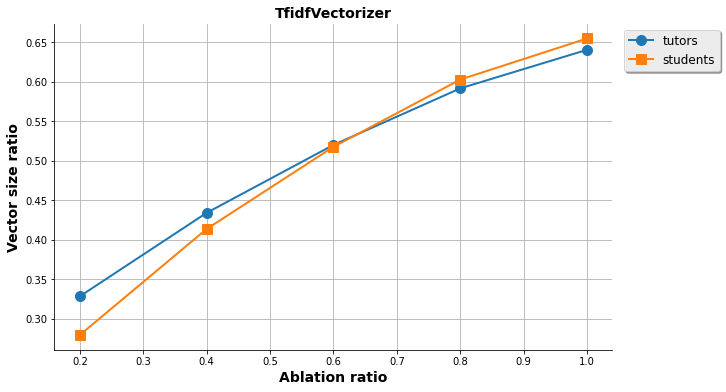

In [11]:
referencia = sizes_matrix[(sizes_matrix.participant=='students_tutors') & (sizes_matrix.ablation>=0.9)].cols_test.values[0]
referencia
tutors_vec = sizes_matrix[sizes_matrix.participant=='tutors'].cols_test.apply(lambda x: x/referencia).to_numpy()
students_vec = sizes_matrix[sizes_matrix.participant=='students'].cols_test.apply(lambda x: x/referencia).to_numpy()

plt.figure(figsize=(10,6))
plt.plot(tokeep_list, tutors_vec, '-o', linewidth=2.0, markersize=10, label='tutors')
plt.plot(tokeep_list, students_vec, '-s', linewidth=2.0, markersize=10, label='students')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.01,1), loc="upper left",fontsize=12)
plt.xlabel('Ablation ratio', fontsize=14)
plt.ylabel('Vector size ratio', fontsize=14)
plt.title('TfidfVectorizer', fontsize=14)
sns.despine()